In [158]:
import pandas as pd
import matplotlib
import numpy as np 
import seaborn as sns
# imports for gradient boosted trees
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier

df = pd.read_csv('data/analysisCSV/latest.csv')
df.drop(df.columns[[0,2]],axis=1,inplace= True)
df['time_series'] = df['year'] + df['month']/12
df = df.dropna(how='any',axis=0)
sdf = df.sample(n=1000,random_state=1)
df_sold = df.loc[df['sold']]

Now we will use time stamps to try to find correlations between listing information and the time that the watches are posted. 
- Questions
    - Has corona virus impacted watch sales and listings?
    - Does time of year affect watch listings?

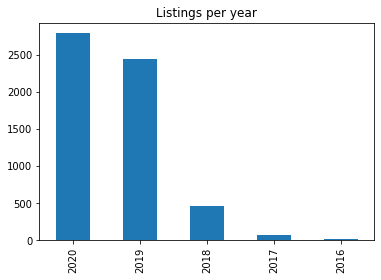

In [99]:
df['year'].value_counts().plot.bar(title="Listings per year")

Now we're going to look at data split into subsets based on year posted


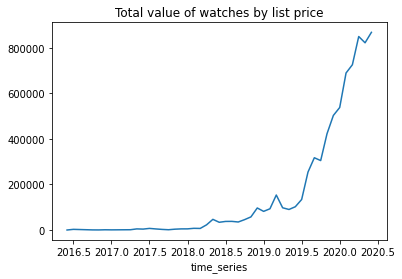

In [100]:
df.groupby(['time_series']).sum()['list_price'].plot.line(title = "Total value of watches by list price")

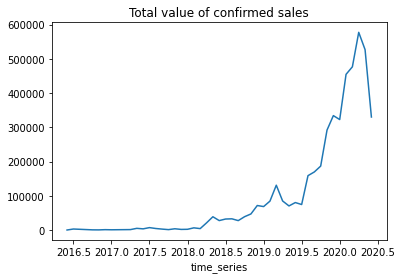

In [150]:
df_sold.groupby(['time_series']).sum()['list_price'].plot.line(title = "Total value of confirmed sales")

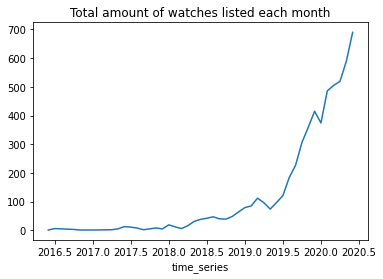

In [102]:
df.groupby(['time_series']).count()['list_price'].plot.line(title = "Total amount of watches listed each month")

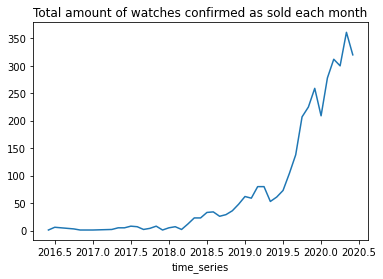

In [103]:
df_sold.groupby(['time_series']).count()['list_price'].plot.line(title = "Total amount of watches confirmed as sold each month")

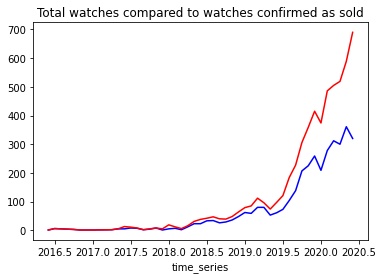

In [106]:
df_sold.groupby(['time_series']).count()['list_price'].plot.line(color = 'b')
df.groupby(['time_series']).count()['list_price'].plot.line(color = 'r',title='Total watches compared to watches confirmed as sold')

After looking at this I got the idea that I wanted to look at the probability that a watch will be sold as a function of how long the watch has been listed for 

In [151]:
a = df.groupby(['time_series']).count()['list_price']
b = df_sold.groupby(['time_series']).count()['list_price']
prob_sold = (a-b)/a
prob_sold = prob_sold.to_frame().reset_index()
prob_sold = prob_sold.rename(columns={'time':'time_series','prob':'list_price'})


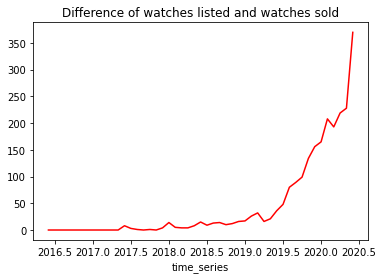

In [105]:
diff = df.groupby(['time_series']).count()['list_price'] - df_sold.groupby(['time_series']).count()['list_price']
diff.plot.line(title='Difference of watches listed and watches sold',color = 'r')

In [97]:
# Trying to fit a line to match the difference in watches sold vs watches listed
test = diff.to_frame().reset_index()
test['time_series'] = test['time_series'] - 2016
fitted = np.polyfit(test['time_series'],test['list_price'],2)
fitted

array([  36.91907057, -128.78131844,   91.59686769])

In the above two graphs we can see the drop off of watch sales as the difference between watches sold vs watches listed grows exponentially. No I want to see if this difference can be seen as starkly with seikos compared to rolexes. Two watches that are amongst the top 10 most popular watch brands on the subreddit despite both being in such different price rangers.

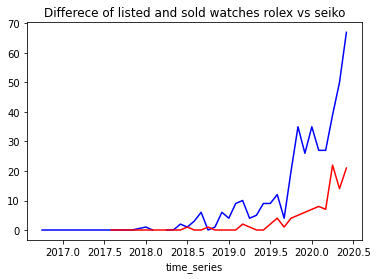

In [107]:
df_seiko = df.loc[df['seiko'] == 1]
df_seiko_sold = df_seiko.loc[df['sold']]
df_rolex = df.loc[df['rolex'] == 1]
df_rolex_sold = df_rolex.loc[df['sold']]
diff_seiko = df_seiko.groupby(['time_series']).count()['list_price'] - df_seiko_sold.groupby(['time_series']).count()['list_price']
diff_rolex = df_rolex.groupby(['time_series']).count()['list_price'] - df_rolex_sold.groupby(['time_series']).count()['list_price']
diff_seiko.plot.line(color = 'b',y = 'seiko')
diff_rolex.plot.line(color = 'r', title = "Differece of listed and sold watches rolex vs seiko", y = 'rolex')

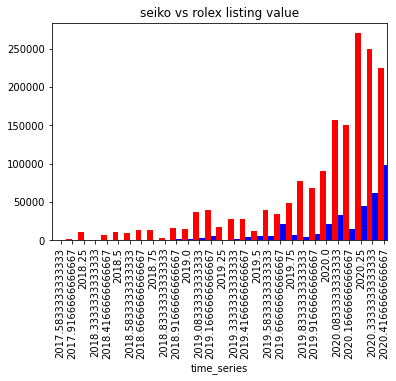

In [124]:
df_seiko.groupby(['time_series']).sum()['list_price'].plot(kind = 'bar',position = 0, color = 'b')
df_rolex.groupby(['time_series']).sum()['list_price'].plot(kind = 'bar',position = 1,color = 'r', title = "seiko vs rolex listing value")

In [152]:
df_rolex['list_price'].describe()

count      430.000000
mean      3891.839535
std       3324.665216
min          2.000000
25%       2100.000000
50%       3100.000000
75%       4700.000000
max      42500.000000
Name: list_price, dtype: float64

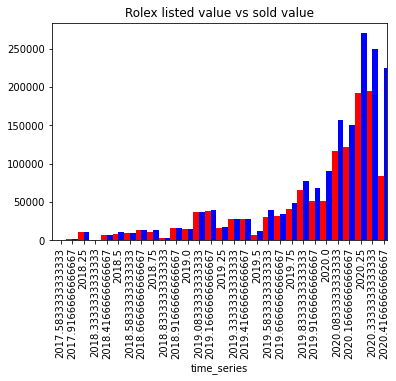

In [153]:
df_rolex.groupby(['time_series']).sum()['list_price'].plot(kind='bar',position=0,color='b')
df_rolex_sold.groupby(['time_series']).sum()['list_price'].plot(kind='bar',position=1,color='r',title='Rolex listed value vs sold value')

Below we are starting the machine learning!

In [171]:
y = df['sold']
X = df.drop(['author','sold'],axis=1, inplace=False)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
clf = GradientBoostingClassifier(n_estimators=100)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
accuracy_score(y_test, y_pred)


0.719585849870578